# Notebook 2 : Clustering

Bonjour, ceci est le 2e notebook du P5 de la formation Data Scientist.

Il portera sur des essais de modélisation.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

## 1. Préparation des données

Je commence par les récupérer

In [2]:
fusion = pd.read_csv("fusion.csv")
fusion = fusion.rename(columns={"commands_amount": "frequency", "payment_value": "monetary"})

Dans un premier temps, je ne conserve que ce qui est lié au RFM (recency/frequency/monetary)

In [3]:
df = fusion.loc[:,["recency(days)","frequency","monetary"]]
df.head()

,recency(days),frequency,monetary
0,519.0,1.0,146.87
1,278.0,1.0,335.48
2,151.0,1.0,157.73
3,218.0,1.0,173.30
4,80.0,1.0,252.25


In [4]:
X = df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. Tests de modélisation

### 2.1 Clustering hiérarchique

Je commence par une approche naïve

In [5]:
#agglo = cluster.AgglomerativeClustering()
#agglo.fit(X_scaled)

Elle a fait planter ma machine.
Il semblerait que le clustering hiérarchique soit trop gourmand pour autant de données.
Essayons avec un  subset.

In [6]:
X_scaled_df = pd.DataFrame(X_scaled)
X_sampled = X_scaled_df.sample(frac = 0.1, random_state = 123).values #Je précise un random_state pour que mes commentaires suivants restent pertinents

In [7]:
agglo = cluster.AgglomerativeClustering()
agglo.fit(X_sampled)

AgglomerativeClustering()

Avant de procéder à un affichage, le clustering hiérarchique prend :

- moins d'une seconde pour 5% des données
- 3 secondes pour 10%
- un peu plus de 10 secondes pour 20%

Dans le souci de ne pas exploser mon temps de calcul, je vais rester à 10%. 

Fort de cette première information, je vais essyaer, avec ce subset, de tester différents paramètres pour mon clustering hiérarchique, et l'évaluer avec, par exemple, le silhouette score.

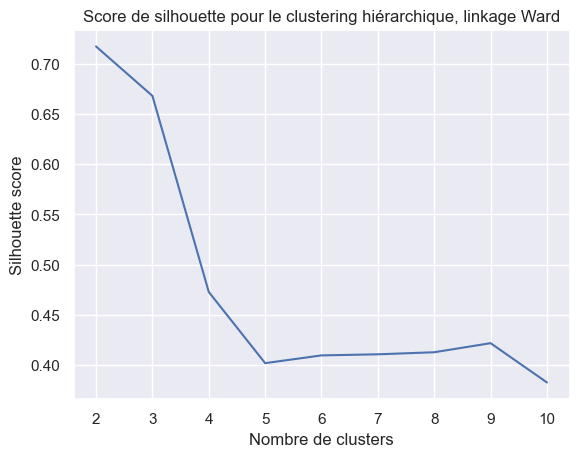

In [8]:
sns.set_theme()

silhouettes = []
for num_clusters in range(2,11):
    agglo = cluster.AgglomerativeClustering(n_clusters = num_clusters)
    agglo.fit(X_sampled)
    silhouettes.append(metrics.silhouette_score(X_sampled, agglo.labels_))
    
plt.plot(range(2,11),silhouettes)
plt.title("Score de silhouette pour le clustering hiérarchique, linkage Ward")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.show()

Il semblerait qu'un faible nombre de clusters amène un bien meilleur silhouette score.

En même temps, cela m'arrange. Un nombre important de clusters serait difficile à interpréter dans notre cas.

Essayons avec différents 'linkages' pour voir si on obtient de meilleurs scores.

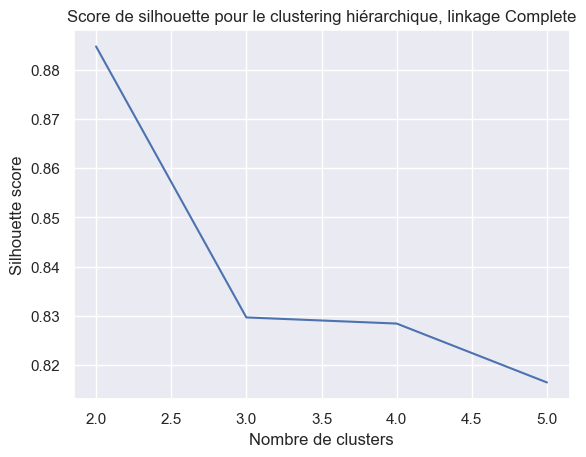

In [9]:
silhouettes = []
for num_clusters in range(2,6):
    agglo = cluster.AgglomerativeClustering(n_clusters = num_clusters, linkage = 'complete')
    agglo.fit(X_sampled)
    silhouettes.append(metrics.silhouette_score(X_sampled, agglo.labels_))
    
plt.plot(range(2,6),silhouettes)
plt.title("Score de silhouette pour le clustering hiérarchique, linkage Complete")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.show()

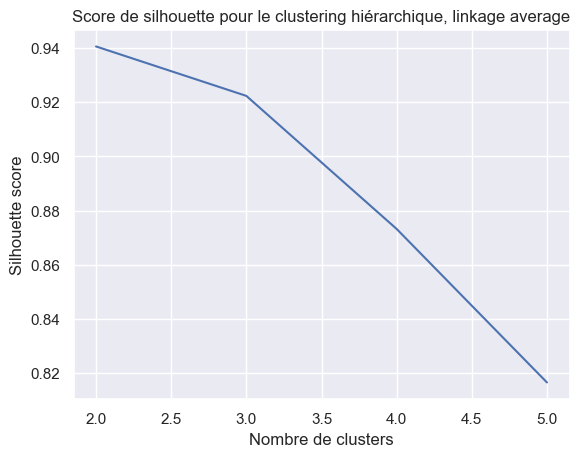

In [10]:
silhouettes = []
for num_clusters in range(2,6):
    agglo = cluster.AgglomerativeClustering(n_clusters = num_clusters, linkage = 'average')
    agglo.fit(X_sampled)
    silhouettes.append(metrics.silhouette_score(X_sampled, agglo.labels_))
    
plt.plot(range(2,6),silhouettes)
plt.title("Score de silhouette pour le clustering hiérarchique, linkage average")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.show()

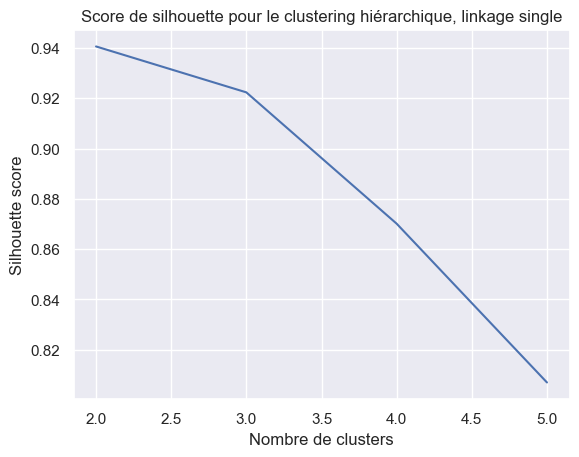

In [11]:
silhouettes = []
for num_clusters in range(2,6):
    agglo = cluster.AgglomerativeClustering(n_clusters = num_clusters, linkage = 'single')
    agglo.fit(X_sampled)
    silhouettes.append(metrics.silhouette_score(X_sampled, agglo.labels_))
    
plt.plot(range(2,6),silhouettes)
plt.title("Score de silhouette pour le clustering hiérarchique, linkage single")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.show()

Testons donc ce qui semble être le meilleur cas : un linkage 'average' ou 'single', et seulement 2 ou 3 clusters.

In [12]:
#J'ai envie de savoir combien d'individus sont dans mes clusters
agglo = cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'average')
agglo.fit(X_sampled)

#Je construis un dataframe me permettant d'observer les clusters en tant que colonne
test_cluster = pd.DataFrame(X_sampled)
test_cluster["cluster"] = agglo.labels_
test_cluster.head()

,0,1,2,cluster
0,-0.163937,-0.160739,-0.410834,0
1,-1.096065,-0.160739,-0.459395,0
2,-1.063473,-0.160739,-0.329464,0
3,-0.874440,-0.160739,-0.485273,0
4,-0.522448,-0.160739,-0.427486,0


In [13]:
test_cluster["cluster"].value_counts()

0    9609
1       1
Name: cluster, dtype: int64

Par exemple, dans ce cas, on a un cluster avec 1 élément, et un autre cluster avec tout le reste. Pas étonnant que le score de silhouette soit bon, mais en tant que clustering, ce résultat n'est vraiment pas terrible.

Je vais avoir envie de faire ce test avec plusieurs modèles, alors je créé une fonction.

In [14]:
def cluster_sizes (model, X):
    model.fit(X)
    test_cluster = pd.DataFrame(X)
    test_cluster["cluster"] = model.labels_
    return (test_cluster["cluster"].value_counts())

In [15]:
#Par exemple, pour un cluster de plus :
agglo = cluster.AgglomerativeClustering(n_clusters = 3, linkage = 'average')
cluster_sizes(agglo, X_sampled)

0    9608
2       1
1       1
Name: cluster, dtype: int64

Une conclusion évidente s'impose à nous : le linkage "average" nous créé des clusters trop petits, il est trop sensible aux outliers. Il n'est pas utilisable en l'état. 

In [16]:
#J'essaie avec le linkage simple :
agglo = cluster.AgglomerativeClustering(n_clusters = 5, linkage = 'single')
cluster_sizes(agglo, X_sampled)

0    9589
1      17
4       2
2       1
3       1
Name: cluster, dtype: int64

Même constat. Je peux éliminer ce modèle.

In [17]:
#Et avec le 'complete' ?
agglo = cluster.AgglomerativeClustering(n_clusters = 5, linkage = 'complete')
cluster_sizes(agglo, X_sampled)

0    9578
2      19
1      11
4       1
3       1
Name: cluster, dtype: int64

C'est la même chose. Il faudra donc utiliser la mesure de Ward, qui est celle utilisée par défaut.

In [18]:
#Par exemple, pour 5 clusters:
agglo = cluster.AgglomerativeClustering(n_clusters = 5)
cluster_sizes(agglo, X_sampled)

2    3722
4    3077
3    2102
0     421
1     288
Name: cluster, dtype: int64

Cela a l'air plus intéressant. En revanche, le silhouette score pour n = 5 était déjà descendu à environ 0.4
Essayons pour n=2 ou n=3

In [19]:
agglo = cluster.AgglomerativeClustering(n_clusters = 2)
cluster_sizes(agglo, X_sampled)

0    9322
1     288
Name: cluster, dtype: int64

In [20]:
agglo = cluster.AgglomerativeClustering(n_clusters = 3)
cluster_sizes(agglo, X_sampled)

0    8901
2     421
1     288
Name: cluster, dtype: int64

Sur le graphique illustrant les silhouette scores, bien plus haut, on remarquait un grand "coude" après n = 3.
Je vais donc choisir ce modèle pour représenter le clustering hiérarchique.

Essayons de représenter les données à l'aide d'un T-SNE.

C:\Users\Yann\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Yann\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


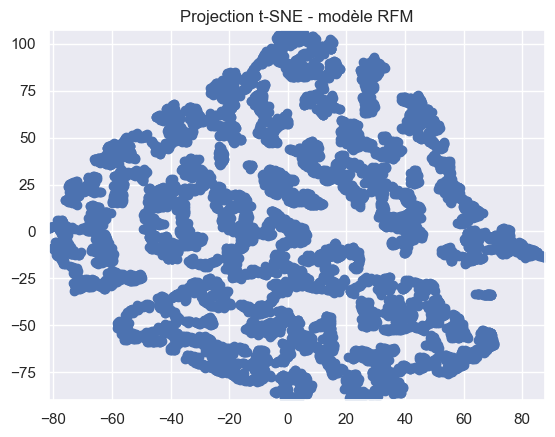

In [21]:
#J'applique le T-SNE
tsne = TSNE(n_components=2, init='pca', n_jobs = -1)
X_trans = tsne.fit_transform(X_sampled)

#Je lui demande d'afficher la projection et les clusters
plt.figure()
plt.scatter(X_trans[:, 0], X_trans[:, 1])
plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])
plt.title('Projection t-SNE - modèle RFM')
plt.show()

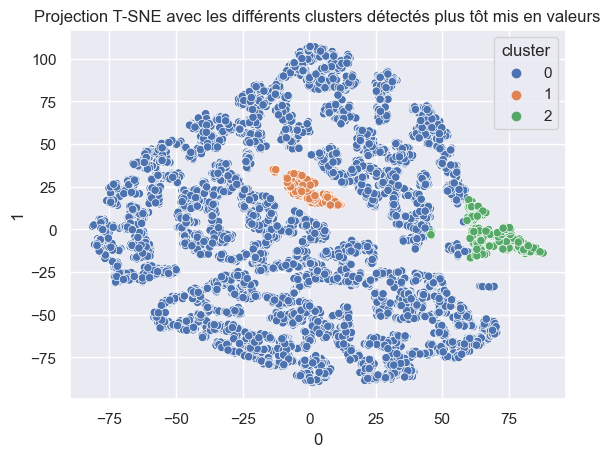

In [22]:
agglo = cluster.AgglomerativeClustering(n_clusters = 3)
agglo.fit(X_sampled)
X_trans = pd.DataFrame(X_trans)
X_trans["cluster"] = agglo.labels_
sns.scatterplot(data = X_trans, x = 0, y = 1, hue = 'cluster', palette = 'deep')
plt.title("Projection T-SNE avec les différents clusters détectés plus tôt mis en valeurs")
plt.show()

Je trouve ce graphique satisfaisant. On s'aperçoit d'une certaine cohérence entre nos clusters. Les deux clusters trouvés se démarquent bien et ne sont pas éparpillés.

### Bilan : Clustering hiérarchique

Dans l'ensemble, le clustering hiérarchique semble plutôt être pertinent. Il sépare assez nettement en plusieurs clusters.  Enfin, ce serait le cas si on travaillait réellement sur l'ensemble des données ici. Malheureusement, on est obligés de sélectionner un sous-échantillon pour l'utiliser. Essayons de faire mieux.

### 2.2 DBSCAN

Pour le DBSCAN, il y a essentiellement deux paramètres à optimiser.
Epsilon (distance entre deux points pour caractériser les points intérieurs)
et n_min (nombre de points qu'il faut toucher pour être considéré intérieur)

Pour cela, je vais effectuer... Une gridsearch, avec un seul fold (l'ensemble du dataset).

In [23]:
params = {
        'epsilon' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
        'min_samples' : [5,6,7,8,9,10]
        }

dbscan = cluster.DBSCAN()

Malheureusement, la fonction GridSearchCV refuse de tourner avec cv = 1.
Je vais donc devoir créer ma propre fonction.

Je laisse les deux prochains Markdowns affichés, parce qu'ils sont extrêmement longs à faire tourner, mais ils m'ont permis de tester de nombreux paramètres pour le DBSCAN. 

Ils sont toujours là, donc vous pouvez les faire tourner si vous le souhaitez.

errors = pd.DataFrame({'epsilon' : [], 'min_samples' : [], 'silhouette' : []})
for epsilon in [0.1, 0.25, 0.5, 1]:
    for min_samples in [5,7,10]:
        dbscan = cluster.DBSCAN(eps = epsilon, min_samples = min_samples)
        dbscan.fit(X_scaled)
        silh = metrics.silhouette_score(X_scaled,dbscan.labels_)
        new_row = {'epsilon': epsilon, 'min_samples': min_samples, 'silhouette': silh}
        errors.loc[len(errors)] = new_row

errors.sort_values('silhouette')

errors2 = pd.DataFrame({'epsilon' : [], 'min_samples' : [], 'silhouette' : []})
for epsilon in [0.6, 0.7, 0.8, 0.9]:
    for min_samples in [6,8,10,12,15]:
        dbscan = cluster.DBSCAN(eps = epsilon, min_samples = min_samples)
        dbscan.fit(X_scaled)
        silh = metrics.silhouette_score(X_scaled,dbscan.labels_)
        new_row = {'epsilon': epsilon, 'min_samples': min_samples, 'silhouette': silh}
        errors.loc[len(errors)] = new_row

errors2.sort_values('silhouette')

Le dataframe concaténé des deux précédentes lignes est ici :

In [24]:
errors_dbscan = pd.read_csv("errors_dbscan.csv")
errors_dbscan.head()

,Unnamed: 0,epsilon,min_samples,silhouette
0,0,0.6,6,0.701457
1,1,0.6,8,0.701306
2,2,0.6,10,0.704669
3,3,0.6,12,0.704658
4,4,0.6,15,0.704522


Dans l'ensemble, on se rend compte que les écarts pour le silhouette score sont très faibles en modifiant les paramètres.

On note que le silhouette score est légèrement meilleur que pour le clustering hiérarchique, mais surtout, le DBSCAN est, lui, capable de tourner (bien qu'un peu difficilement) sur l'ensemble des données, et non pas un simple subset.

Je vais maintenant faire d'autres observations, afin de voir si le DBSCAN est réellement viable (nombre de clusters, population de chaque cluster, interprétabilité...)

Commençons par la population des clusters.

In [25]:
dbscan = cluster.DBSCAN(eps = 0.6, min_samples = 10)
cluster_sizes(dbscan, X_scaled)

 0    93060
 1     2678
 2      190
-1      149
 3       18
Name: cluster, dtype: int64

On a détecté 4 clusters, dont un très majoritaire. 149 points n'ont pas pu être classés. (c'est relativement beaucoup)

In [26]:
dbscan = cluster.DBSCAN(eps = 0.9, min_samples = 10)
cluster_sizes(dbscan, X_scaled)

 0    93107
 2     2688
 3      193
-1       69
 4       24
 1       14
Name: cluster, dtype: int64

En augmentant epsilon, on réduit le nombre d'individus non classés, mais on fait apparaître de tout petits cluster, difficiles à interpréter.

In [27]:
dbscan = cluster.DBSCAN(eps = 1, min_samples = 5)
cluster_sizes(dbscan, X_scaled)

 0    93131
 2     2690
 3      193
-1       38
 5       24
 4        8
 1        6
 6        5
Name: cluster, dtype: int64

Globalement, par rapport au clustering hiérarchique, on détecte un "gros" cluster de moins. (Si on extrapole les résultats de notre CAH sur le subset)

On a en outre toujours des points isolés. 

L'avantage principal est qu'on peut travailler directement sur l'ensemble des données, et non un subset.

Toutefois, un autre algorithme le permet aussi, et nous allons tester s'il est plus satisfaisant ou non.

## 2.3 K-Means

Heureusement, cette fois-ci, il n'y a qu'un paramètre à tester : le nombre de clusters.
Je procède comme je l'avais fait pour le CAH.

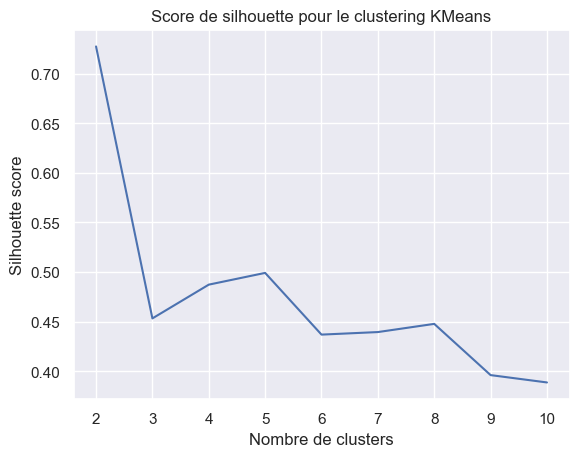

In [28]:
silhouettes = []
for num_clusters in range(2,11):
    km = cluster.KMeans(n_clusters = num_clusters)
    km.fit(X_scaled)
    silhouettes.append(metrics.silhouette_score(X_scaled, km.labels_))
    
plt.plot(range(2,11),silhouettes)
plt.title("Score de silhouette pour le clustering KMeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.show()

2 étant un nombre assez faible de clusters, je préférerais travailler avec k = 5 par exemple.

Regardons la répartition des clusters dans ce cas.

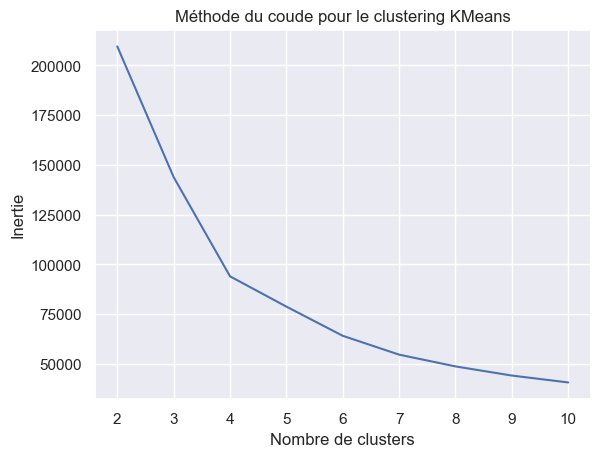

In [29]:
inertias = []
for num_clusters in range(2,11):
    km = cluster.KMeans(n_clusters = num_clusters)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    
plt.plot(range(2,11),inertias)
plt.title("Méthode du coude pour le clustering KMeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.show()

Le "coude" s'observe assez clairement pour n_clusters = 4.
Pour orienter mon choix, je regarde les cluster sizes pour n = 4 et n = 5.

In [30]:
km_5 = cluster.KMeans(n_clusters = 5)
cluster_sizes(km_5, X_scaled)

0    50332
1    37398
4     4770
2     2933
3      662
Name: cluster, dtype: int64

In [31]:
km_4 = cluster.KMeans(n_clusters = 4)
cluster_sizes(km_4, X_scaled)

0    52122
1    38459
3     2933
2     2581
Name: cluster, dtype: int64

Finalement, je vais conserver n = 4 pour deux raisons :

- Faire confiance à la elbow method.

- Probablement une interprétation plus simple.

Essayons de voir à quoi cela ressemble sur une projection T-SNE.

C:\Users\Yann\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Yann\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


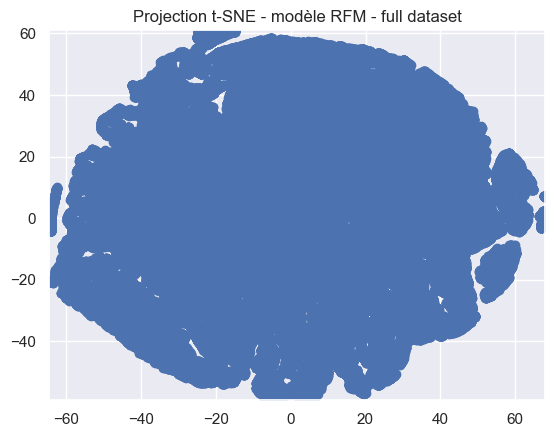

In [32]:
#J'applique le T-SNE
tsne = TSNE(n_components=2, init='pca', n_jobs = -1)
X_trans = tsne.fit_transform(X_scaled)

#Je lui demande d'afficher la projection et les clusters
plt.figure()
plt.scatter(X_trans[:, 0], X_trans[:, 1])
plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])
plt.title('Projection t-SNE - modèle RFM - full dataset')
plt.show()

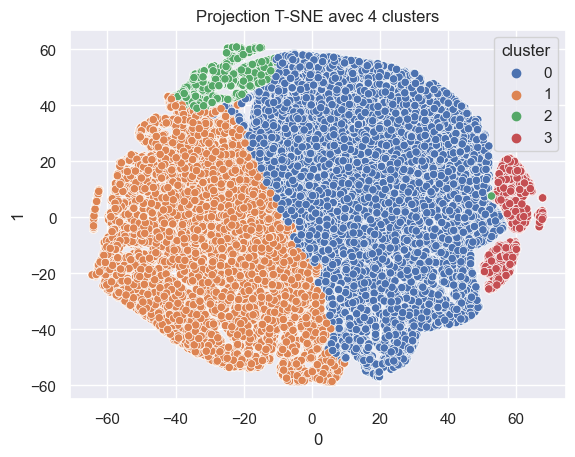

In [33]:
X_trans = pd.DataFrame(X_trans)
X_trans["cluster"] = km_4.labels_
sns.scatterplot(data = X_trans, x = 0, y = 1, hue = 'cluster', palette = 'deep')
plt.title("Projection T-SNE avec 4 clusters")
plt.show()

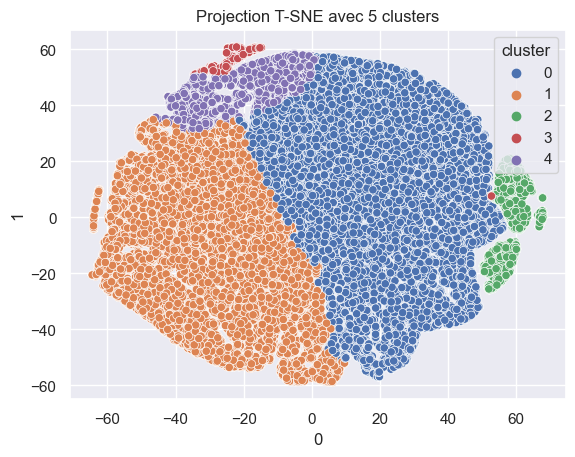

In [34]:
X_trans = pd.DataFrame(X_trans)
X_trans["cluster"] = km_5.labels_
sns.scatterplot(data = X_trans, x = 0, y = 1, hue = 'cluster', palette = 'deep')
plt.title("Projection T-SNE avec 5 clusters")
plt.show()

J'ai tout de même voulu visualiser cela pour k = 5, parce que pourquoi pas, et parce que c'est joli (je trouve). La différence entre les deux est très faible, le cluster du haut se retrouve coupé en deux, et c'est tout.

A partir de ce point, on s'intéressera seulement à k = 4.

#### Conclusion sur le modèle

Le KMeans s'exécute sur l'intégralité du dataset, avec une vitesse bien plus intéressante que DBSCAN. Il ne laisse personne de côté et les clusters semblent mieux "répartis".

De plus, par rapport au clustering hiérarchique, il a l'avantage de tourner sur l'intégralité des données.

Malgré son silhouette score plus faible (Ce qui s'explique par la séparation du "cluster monstre" en deux parties), il semble être le meilleur modèle.

## 3. Exploitation du modèle choisi

Le modèle choisi est donc un K-Means, avec k = 4.

Maintenant, je souhaite découper mes données d'origine en fonction des clusters, et jeter un oeil aux indicateurs statistiques.

Pour comparaison, voici les indicateurs globaux.

In [35]:
df.describe()

,recency(days),frequency,monetary
count,96095.000000,96095.000000,96095.000000
mean,288.150008,1.034102,161.015338
std,153.413215,0.212157,222.196432
min,0.000000,1.000000,0.000000
25%,164.000000,1.000000,62.120000
50%,269.000000,1.000000,105.420000
75%,397.000000,1.000000,176.865000
max,773.000000,17.000000,13664.080000


In [36]:
#J'ajoute la colonne "clusters"
df["cluster"] = km_4.labels_

#Je sépare en 4 dataframes selon l'appartenance aux clusters
df_cl0 = df.loc[df["cluster"] == 0,:]
df_cl1 = df.loc[df["cluster"] == 1,:]
df_cl2 = df.loc[df["cluster"] == 2,:]
df_cl3 = df.loc[df["cluster"] == 3,:]

In [37]:
df_cl0.describe()

,recency(days),frequency,monetary,cluster
count,52122.000000,52122.0,52122.000000,52122.0
mean,178.052051,1.0,134.067201,0.0
std,72.947310,0.0,106.646988,0.0
min,0.000000,1.0,0.000000,0.0
25%,114.000000,1.0,60.802500,0.0
50%,180.000000,1.0,103.550000,0.0
75%,240.000000,1.0,170.000000,0.0
max,309.000000,1.0,676.160000,0.0


In [38]:
df_cl1.describe()

,recency(days),frequency,monetary,cluster
count,38459.000000,38459.0,38459.000000,38459.0
mean,438.644947,1.0,132.921006,1.0
std,96.536625,0.0,107.072769,0.0
min,309.000000,1.0,1.020000,1.0
25%,351.000000,1.0,60.850000,1.0
50%,426.000000,1.0,101.020000,1.0
75%,513.000000,1.0,166.740000,1.0
max,773.000000,1.0,719.760000,1.0


In [39]:
df_cl2.describe()

,recency(days),frequency,monetary,cluster
count,2581.000000,2581.00000,2581.000000,2581.0
mean,292.525765,1.00310,1143.896620,2.0
std,153.145596,0.06218,654.649819,0.0
min,41.000000,1.00000,623.680000,2.0
25%,164.000000,1.00000,761.820000,2.0
50%,278.000000,1.00000,921.240000,2.0
75%,401.000000,1.00000,1311.460000,2.0
max,743.000000,3.00000,13664.080000,2.0


In [40]:
df_cl3.describe()

,recency(days),frequency,monetary,cluster
count,2933.000000,2933.000000,2933.000000,2933.0
mean,267.470508,2.114558,143.372688,3.0
std,144.493858,0.516940,120.203348,0.0
min,1.000000,2.000000,14.290000,3.0
25%,152.000000,2.000000,71.445000,3.0
50%,248.000000,2.000000,110.040000,3.0
75%,365.000000,2.000000,172.155000,3.0
max,740.000000,17.000000,1170.040000,3.0


On a donc 4 clusters assez bien interprétables. Mais plutôt que de le faire sur ces tableaux "bruts", essayons une visualisation.

...

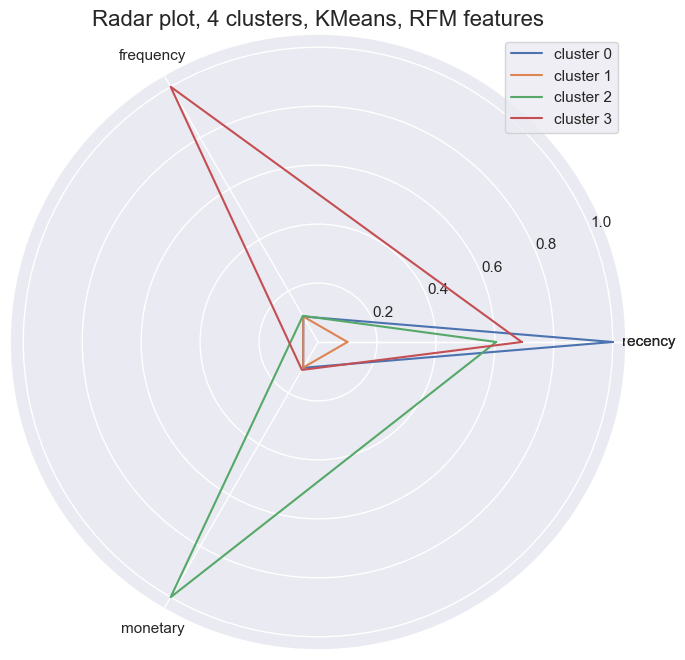

In [41]:
### Essayons avec un radar chart, pour visualiser cela peut-être plus clairement

#Je veux que mes données s'affichent bien, j'utilise un MinMaxScaler sur [0.1, 1]
minmax = MinMaxScaler(feature_range=(0.1,1))
pour_radar = pd.DataFrame(X_scaled)
 
pour_radar["cluster"] = km_4.labels_
pour_radar = pour_radar.groupby("cluster").mean().reset_index()
pour_radar[0] = -pour_radar[0] #C'est pour que l'affichage du 'recency' soit plus intuitif
pour_radar = pour_radar.values
pour_radar = minmax.fit_transform(pour_radar)
pour_radar = pd.DataFrame(pour_radar)
pour_radar = pour_radar.rename(columns={1: "recency", 2: "frequency", 3: "monetary"})

#Je prépare les données à tracer
categories = ["recency" , "frequency" , "monetary"]
categories = [*categories, categories[0]]

cluster0 = pour_radar.loc[0, categories]
cluster1 = pour_radar.loc[1, categories]
cluster2 = pour_radar.loc[2, categories]
cluster3 = pour_radar.loc[3, categories]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster0))

#Pour le tracé
plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster0, label='cluster 0')
plt.plot(label_loc, cluster1, label='cluster 1')
plt.plot(label_loc, cluster2, label='cluster 2')
plt.plot(label_loc, cluster3, label='cluster 3')
plt.title('Radar plot, 4 clusters, KMeans, RFM features', size=16)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

Comme pour mon analyse des indicateurs statistiques, on se rend compte que nos clients ont été divisés en 4 groupes bien définis :

- Les clients qui sont revenus
- Les clients qui ont payé plus cher que la moyenne
- Ceux qui n'ont aucune de ces caractéristiques mais qui sont venus plutôt récemment
- Ceux qui n'ont aucune de ces caractéristiques et dont la commande remonte à un certain temps déjà.




### Conclusion (RFM)

Avec le K-Means, on a réussi à produire et interpréter 4 clusters :

- Les clients "réguliers"
- Les moins réguliers, mais fortement dépensiers
- Les clients qui ne sont venus qu'une fois, ont dépensé peu, et il y a longtemps.
- Les clients qui ne sont venu qu'une fois, ont dépensé peu... Pour l'instant, car c'est récent.

On peut déjà se satisfaire de cela, mais on peut aussi décider d'ajouter une (ou plusieurs) feature(s).
Commençons par essayer :

## 4. L'ajout du review score

A présent, comme je l'ai évoqué dans le notebook précédent, je vais vouloir ajouter une 4e feature, afin d'affiner mon clustering. Il s'agit du review score.

In [42]:
df_2 = fusion.loc[~(fusion["review_score"].isnull()),["recency(days)","frequency","monetary","review_score"]]
df_2.shape

(95379, 4)

Cette fois-ci, je ne reteste pas tous les modèles différents, il me paraît assez clair que c'est le K-Means qui restera le meilleur. DBSCAN trouve trop de points isolés et est plus lent à tourner, tandis que le CAH ne peut pas performer avec autant de données.

En revanche, il est possible que notre nombre de clusters s'en retrouve modifié.

### 4.1 Recherche du meilleur modèle

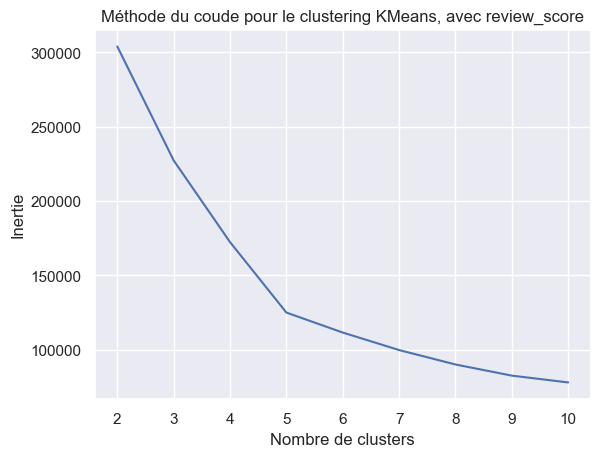

In [43]:
#Préparation des données
X = df_2.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Test du coude
inertias = []
for num_clusters in range(2,11):
    km = cluster.KMeans(n_clusters = num_clusters)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    
plt.plot(range(2,11),inertias)
plt.title("Méthode du coude pour le clustering KMeans, avec review_score")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.show()

Le "coude" est très visible, pour k = 5.
Pour prendre la décision du nombre de clusters, j'ajoute à cela l'observation du silhouette score.

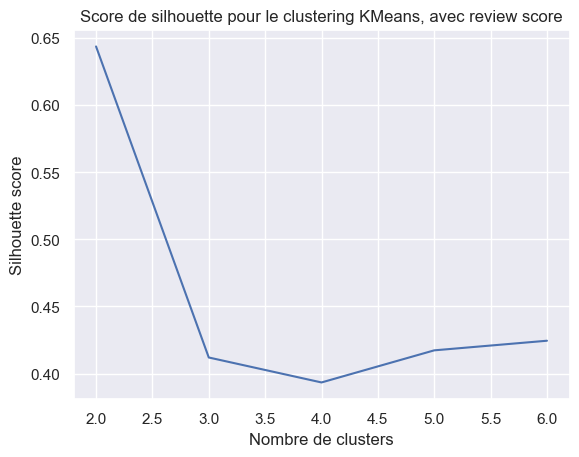

In [44]:
silhouettes = []
for num_clusters in range(2,7):
    km = cluster.KMeans(n_clusters = num_clusters)
    km.fit(X_scaled)
    silhouettes.append(metrics.silhouette_score(X_scaled, km.labels_))
    
plt.plot(range(2,7),silhouettes)
plt.title("Score de silhouette pour le clustering KMeans, avec review score")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.show()

Visiblement, 5 clusters semble s'imposer par rapport à 4 clusters comme avant.
Regardons tout de même le nombre d'individus par cluster.

In [45]:
km_5 = cluster.KMeans(n_clusters = 5)
cluster_sizes(km_5, X_scaled)

1    41956
0    31615
2    16731
3     2924
4     2153
Name: cluster, dtype: int64

In [46]:
km_4 = cluster.KMeans(n_clusters = 4)
cluster_sizes(km_4, X_scaled)

0    42901
2    32440
1    17107
3     2931
Name: cluster, dtype: int64

Il ne semble y avoir aucun problème pour k = 5, je valide donc ce modèle.

### 4.2 Exploitation du modèle

Commençons par observer les clusters sur un T-SNE

C:\Users\Yann\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Yann\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


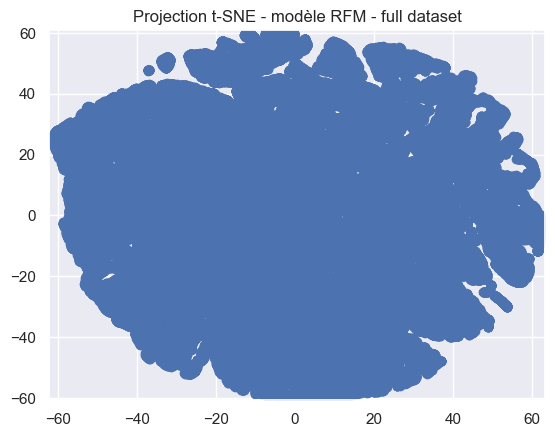

In [47]:
#J'applique le T-SNE
tsne = TSNE(n_components=2, init='pca', n_jobs = -1)
X_trans = tsne.fit_transform(X_scaled)

#Je lui demande d'afficher la projection et les clusters
plt.figure()
plt.scatter(X_trans[:, 0], X_trans[:, 1])
plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])
plt.title('Projection t-SNE - modèle RFM - full dataset')
plt.show()

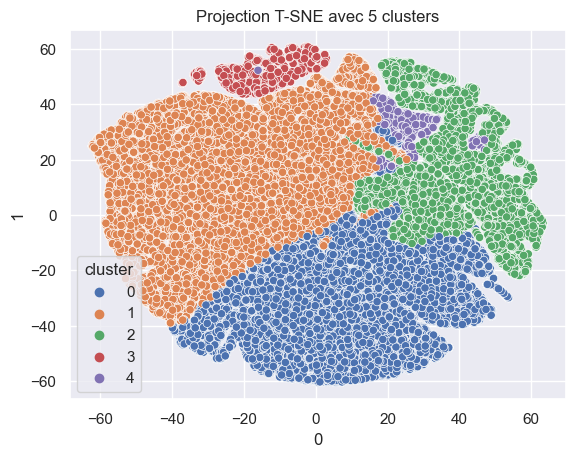

In [48]:
X_trans = pd.DataFrame(X_trans)
X_trans["cluster"] = km_5.labels_
sns.scatterplot(data = X_trans, x = 0, y = 1, hue = 'cluster', palette = 'deep')
plt.title("Projection T-SNE avec 5 clusters")
plt.show()

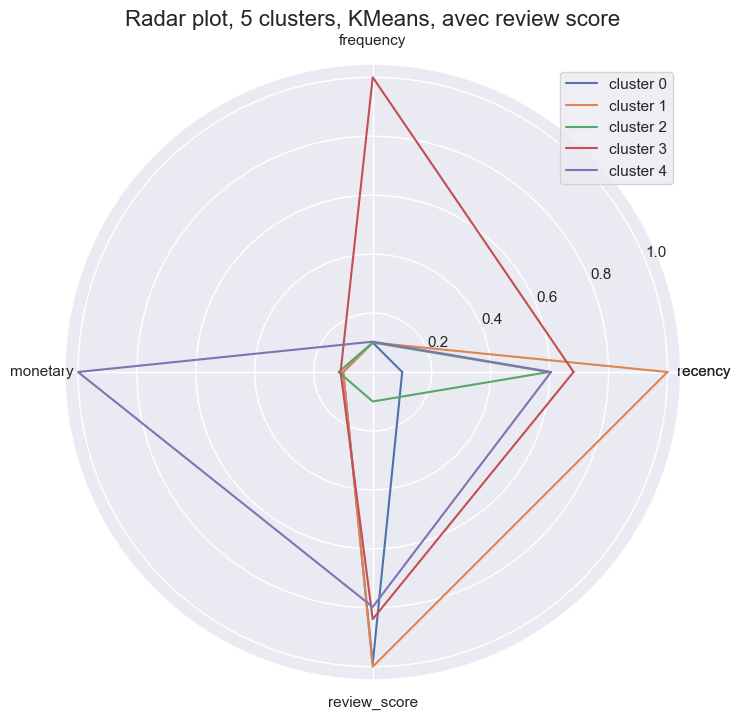

In [49]:
### Essayons avec un radar chart, pour visualiser cela peut-être plus clairement

#Je veux que mes données s'affichent bien, j'utilise un MinMaxScaler sur [0.1, 1]
minmax = MinMaxScaler(feature_range=(0.1,1))
pour_radar = pd.DataFrame(X_scaled)
 
pour_radar["cluster"] = km_5.labels_
pour_radar = pour_radar.groupby("cluster").mean().reset_index()
pour_radar[0] = -pour_radar[0] #C'est pour que l'affichage du 'recency' soit plus intuitif
pour_radar = pour_radar.values
pour_radar = minmax.fit_transform(pour_radar)
pour_radar = pd.DataFrame(pour_radar)
pour_radar = pour_radar.rename(columns={1: "recency", 2: "frequency", 3: "monetary", 4 : "review_score"})

#Je prépare les données à tracer
categories = ["recency" , "frequency" , "monetary", "review_score"]
categories = [*categories, categories[0]]

cluster0 = pour_radar.loc[0, categories]
cluster1 = pour_radar.loc[1, categories]
cluster2 = pour_radar.loc[2, categories]
cluster3 = pour_radar.loc[3, categories]
cluster4 = pour_radar.loc[4, categories]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster0))

#Pour le tracé
plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster0, label='cluster 0')
plt.plot(label_loc, cluster1, label='cluster 1')
plt.plot(label_loc, cluster2, label='cluster 2')
plt.plot(label_loc, cluster3, label='cluster 3')
plt.plot(label_loc, cluster4, label='cluster 4')
plt.title('Radar plot, 5 clusters, KMeans, avec review score', size=16)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

Cela peut paraître quelque peu difficile à lire, toutefois, je peux donner des éléments de lecture "à première vue".

- Plus l'aire à l'intérieur d'une figure est importante, plus le groupe de clients est pertinent pour Olist

- Les "haters" (groupe avec faible review score) paient peu et ne reviennent pas

Pour le détail cluster par cluster, on peut regarder individuellement sur le radar chart ci-dessus, ou on peut aussi regarder les indicateurs statistiques :

In [50]:
#Comme la fois précédente, je vais observer un par un les clusters. Pour référence :
df_2.describe()

,recency(days),frequency,monetary,review_score
count,95379.000000,95379.000000,95379.000000,95379.000000
mean,287.972887,1.034263,160.755058,4.084994
std,153.420852,0.212725,220.892001,1.341631
min,0.000000,1.000000,0.000000,1.000000
25%,163.500000,1.000000,62.045000,4.000000
50%,269.000000,1.000000,105.380000,5.000000
75%,397.000000,1.000000,176.715000,5.000000
max,773.000000,17.000000,13664.080000,5.000000


In [51]:
#J'ajoute la colonne "clusters"
df_2["cluster"] = km_5.labels_

#Je sépare en 4 dataframes selon l'appartenance aux clusters
df2_cl0 = df_2.loc[df_2["cluster"] == 0,:]
df2_cl1 = df_2.loc[df_2["cluster"] == 1,:]
df2_cl2 = df_2.loc[df_2["cluster"] == 2,:]
df2_cl3 = df_2.loc[df_2["cluster"] == 3,:]
df2_cl4 = df_2.loc[df_2["cluster"] == 4,:]

In [52]:
df2_cl0.describe()

,recency(days),frequency,monetary,review_score,cluster
count,31615.000000,31615.0,31615.000000,31615.00000,31615.0
mean,442.380452,1.0,132.735070,4.63152,0.0
std,95.181898,0.0,110.363769,0.59699,0.0
min,306.000000,1.0,2.790000,2.00000,0.0
25%,358.000000,1.0,60.090000,4.00000,0.0
50%,432.000000,1.0,99.430000,5.00000,0.0
75%,514.000000,1.0,164.790000,5.00000,0.0
max,744.000000,1.0,784.800000,5.00000,0.0


In [53]:
df2_cl1.describe()

,recency(days),frequency,monetary,review_score,cluster
count,41956.000000,41956.0,41956.000000,41956.000000,41956.0
mean,171.189079,1.0,132.263376,4.669928,1.0
std,72.602432,0.0,107.534902,0.563271,0.0
min,44.000000,1.0,0.000000,3.000000,1.0
25%,108.000000,1.0,59.090000,4.000000,1.0
50%,169.000000,1.0,101.645000,5.000000,1.0
75%,233.000000,1.0,167.140000,5.000000,1.0
max,307.000000,1.0,727.100000,5.000000,1.0


In [54]:
df2_cl2.describe()

,recency(days),frequency,monetary,review_score,cluster
count,16731.000000,16731.0,16731.000000,16731.000000,16731.0
mean,292.400394,1.0,151.240571,1.593629,2.0
std,133.182881,0.0,127.639764,0.814435,0.0
min,0.000000,1.0,0.000000,1.000000,2.0
25%,210.000000,1.0,65.365000,1.000000,2.0
50%,273.000000,1.0,112.420000,1.000000,2.0
75%,355.000000,1.0,189.260000,2.000000,2.0
max,773.000000,1.0,793.090000,3.000000,2.0


In [55]:
df2_cl3.describe()

,recency(days),frequency,monetary,review_score,cluster
count,2924.000000,2924.000000,2924.000000,2924.000000,2924.0
mean,267.208276,2.114911,143.142826,4.118211,3.0
std,144.556019,0.517696,120.130691,1.141307,0.0
min,1.000000,2.000000,14.290000,1.000000,3.0
25%,152.000000,2.000000,71.378750,3.500000,3.0
50%,247.000000,2.000000,109.937500,4.500000,3.0
75%,365.000000,2.000000,172.047500,5.000000,3.0
max,740.000000,17.000000,1170.040000,5.000000,3.0


In [56]:
df2_cl4.describe()

,recency(days),frequency,monetary,review_score,cluster
count,2153.000000,2153.000000,2153.000000,2153.000000,2153.0
mean,290.214120,1.003716,1225.285478,3.976312,4.0
std,155.509458,0.068066,670.578612,1.449313,0.0
min,52.000000,1.000000,666.040000,1.000000,4.0
25%,160.000000,1.000000,828.320000,3.000000,4.0
50%,273.000000,1.000000,1014.990000,5.000000,4.0
75%,406.000000,1.000000,1388.680000,5.000000,4.0
max,743.000000,3.000000,13664.080000,5.000000,4.0


### Conclusion : Review score

Les 5 clusters semblent tout à fait pertinents, ainsi qu'interprétables. L'ajout de cette feature me semble tout à fait justifié.

# Conclusion globale : Modélisation

La modélisation la plus pertinente me semble être la dernière :

- 4 features (recency, monetary, frequency, review score). J'ai pensé à en ajouter d'autres que je n'ai au final pas utilisées, mais elles seraient en fait toutes liées à d'autres questions. Par exemple, le temps de livraison servirait plutôt à expliquer la mauvaise note (cf. coefficient de corrélation trouvé dans l'analyse), le lieu de résidence, ou encore la catégorie de produit acheté nous permettraient aussi éventuellement d'affiner la segmentation, mais j'ai préféré conserver l'axe "comportement du client" à fond dans ce travail, quitte à ce que le client demande un aprofondissement par la suite.

- Le K-means, je l'ai déjà expliqué, est meilleur que les autres modèles dans notre cas.

- J'ai également déjà discuté de la décision de conserver 5 clusters.

On a donc séparé les clients en 5 grandes catégories, détaillées dans la partie qui nous précède tout juste : 

- Les clients qui reviennent

- Les clients qui paient plus cher que la moyenne

- Les "haters"

- Ceux qui n'ont pas ces caractéristiques particulières, et qui sont venus récemment (Probablement des cibles à faire revenir puisqu'elles ont bien noté la livraison)

- Les mêmes que les derniers, mais moins récents.

Par rapport à la classification sans review score, on n'a pas seulement ajouté la catégorie des haters, on a aussi, dans les deux derniers clusters que je viens d'évoquer, éliminé les haters. Donc on a des clients qui ont commandé, pour un montant raisonnable et une seule fois, mais qui ont été satisfaits. 

Peut-être qu'Olist voudrait alors raviver les "bons souvenirs" de ces clients pour les faire revenir sur le site et passer une nouvelle commande.

In [57]:
df_2.to_csv("4_features.csv", index = False)